# Resumes PDFs Text Analysis

In [1]:
import fitz
import pandas as pd
import numpy as np

## Reading Resumes PDF with PyMuPDF

In [2]:
cv_text_list = []
for i in range(1, 1000):
    try:
        doc = fitz.open(f"data/ResumesPDF/cv ({i}).pdf")
        page = doc[0]
        text = page.get_text()
        cv_text_list.append(text)
        doc.close()
    except Exception as e:
        print(e)

In [3]:
for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')

One97 Communications Limited 
Data Scientist Jan 2019 to Till Date 
Detect important information from images and redact
required fields. YOLO CNN Object-detection, OCR
Insights, find anomaly or performance drop in all
possible sub-space. 
Predict the Insurance claim probability. Estimate the
premium amount to be charged
B.Tech(Computer Science) from SGBAU university in
2017. 
M.Tech (Computer Science Engineering) from Indian
Institute of Technology (IIT), Kanpur in 2019
WORK EXPERIENCE
EDUCATION
MACY WILLIAMS
DATA SCIENTIST
Data Scientist working  on problems related to market research and customer analysis. I want to expand my arsenal of
application building and work on different kinds of problems. Looking for a role where I can work with a coordinative team
and exchange knowledge during the process.
Java, C++, Python, Machine Learning, Algorithms, Natural Language Processing, Deep Learning, Computer Vision, Pattern
Recognition, Data Science, Data Analysis, Software Engineer, Data Ana

## Reading Resumes PDF with pdfplumber

In [4]:
"""import pdfplumber

cv_text_list = []
for i in range(1, 5035):
    try:
        with pdfplumber.open(f'data/ResumesPDF/cv ({i}).pdf') as pdf:
            # Acessar a primeira página
            if pdf.pages:
                pagina = pdf.pages[0]

            # Extrair texto
            texto = pagina.extract_text()
            cv_text_list.append(texto)
    except Exception as e:
        print(e)"""

"import pdfplumber\n\ncv_text_list = []\nfor i in range(1, 5035):\n    try:\n        with pdfplumber.open(f'data/ResumesPDF/cv ({i}).pdf') as pdf:\n            # Acessar a primeira página\n            if pdf.pages:\n                pagina = pdf.pages[0]\n\n            # Extrair texto\n            texto = pagina.extract_text()\n            cv_text_list.append(texto)\n    except Exception as e:\n        print(e)"

In [5]:
"""for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')"""

"for text in cv_text_list[:10]:\n    print(text)\n    print('\n')\n    print('==========================')"

## Reading PDFs with PyPDF2

In [6]:
"""import PyPDF2

cv_text_list = []
for i in range(1, 5035):
    try:
        with open(f'data/ResumesPDF/cv ({i}).pdf', 'rb') as file:
            pdf = PyPDF2.PdfReader(file)
            if pdf.pages:
                pagina = pdf.pages[0]
            texto = pagina.extract_text()
            cv_text_list.append(texto)
    except Exception as e:
        print(e)"""

"import PyPDF2\n\ncv_text_list = []\nfor i in range(1, 5035):\n    try:\n        with open(f'data/ResumesPDF/cv ({i}).pdf', 'rb') as file:\n            pdf = PyPDF2.PdfReader(file)\n            if pdf.pages:\n                pagina = pdf.pages[0]\n            texto = pagina.extract_text()\n            cv_text_list.append(texto)\n    except Exception as e:\n        print(e)"

In [7]:
"""for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')"""

"for text in cv_text_list[:10]:\n    print(text)\n    print('\n')\n    print('==========================')"

## Configure Spark ENV Vars

In [8]:
import os
os.environ["PYSPARK_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"

## Creating Spark Session

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA Resumes").master("local[*]").config("spark.driver.memory", "6g").getOrCreate()
spark

In [10]:
resumes_data = spark.createDataFrame([(text, ) for text in cv_text_list], ['text_resume'])
resumes_data.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
resumes_data.count()

999

## Data Pipeline

In [12]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf, col
import spacy
from pyspark.ml import Transformer

class TokenFilterChar(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(TokenFilterChar, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        def remove_single_char_tokens(tokens):
            return [t for t in tokens if len(t) > 1]

        filter_udf = udf(remove_single_char_tokens, ArrayType(StringType()))
        return df.withColumn(self.outputCol, filter_udf(col(self.inputCol)))


class NerTransformer(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(NerTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        nlp = spacy.load("en_core_web_trf")

        def extract_entities(text):
            if isinstance(text, list):
                text = " ".join(text)
            if not isinstance(text, str):
                return []
            doc = nlp(text)
            return [str(ent.text) for ent in doc.ents]

        ner_udf = udf(extract_entities, ArrayType(StringType()))
        return df.withColumn(self.outputCol, ner_udf(col(self.inputCol)))

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

tokenizer  = RegexTokenizer(inputCol="text_resume", outputCol="words_resume", pattern="[\\s+|\\W]")
remover = StopWordsRemover(inputCol="words_resume", outputCol="words_clean")
token_filter_char = TokenFilterChar(inputCol="words_clean", outputCol="words_resume")
ner_transformer = NerTransformer(inputCol="words_resume", outputCol="words_ner")
vectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="features_count")

pipeline = Pipeline(stages=[tokenizer, remover, token_filter_char, ner_transformer, vectorizer])

In [14]:
resumes_data.cache()
pipe = pipeline.fit(resumes_data)
resumes_data = pipe.transform(resumes_data)
resumes_data.limit(5).show(truncate=False)

C:\Users\Victor Dantas\PycharmProjects\EDA_Resumes\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Tokens Frequency

In [15]:
pipe.stages

[RegexTokenizer_277b5410c63b,
 StopWordsRemover_4d789a236fb2,
 TokenFilterChar_64f02b93eaf5,
 NerTransformer_e15cbe97de09,
 CountVectorizerModel: uid=CountVectorizer_3110571913f0, vocabularySize=24174]

In [16]:
count_vec_model = pipe.stages[4]
vocab = count_vec_model.vocabulary

In [17]:
features = resumes_data.select("features_count").toPandas()["features_count"]
features_array = np.array([vec.toArray() for vec in features])

# Soma as frequências por coluna
freq_total = np.sum(features_array, axis=0)

In [18]:
import pandas as pd

freq_df = pd.DataFrame({
    "token": vocab,
    "frequency": freq_total
}).sort_values(by="frequency", ascending=False)

In [19]:
freq_df.head()

,token,frequency
0,experience,1186.0
1,com,1114.0
2,work,1041.0
3,skills,856.0
4,e,827.0


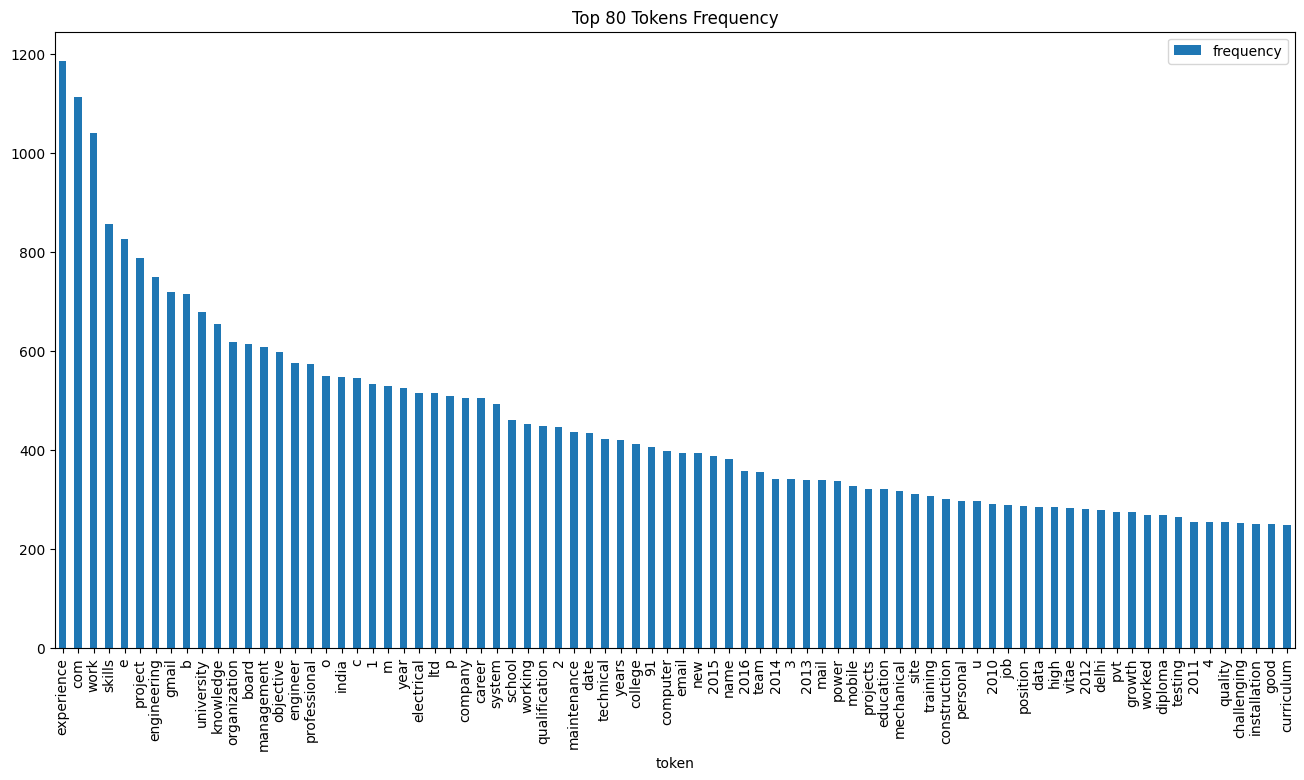

In [20]:
import matplotlib.pyplot as plt
top_k = 80
freq_df.iloc[:top_k].plot(kind="bar", x="token", y="frequency", figsize=(16, 8))
plt.xticks(rotation=90)
plt.title(f"Top {top_k} Tokens Frequency")
plt.show()

## Mean and Median Tokens By Document

In [21]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Mean of tokens by Document: {freq_total_rows.mean():.0f}')

Mean of tokens by Document: 170


In [22]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Median of tokens by Document: {np.median(freq_total_rows):.0f}')

Median of tokens by Document: 157


In [23]:
resumes_data.select('words_ner').limit(5).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+
|words_ner                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------+
|[one97 communications, jan 2019, yolo cnn, sgbau university, 2017, indian institute, 2019, macy williams, arsenal, java, pyspark kubeflow]|
|[keisuke yamamoto, months, sai technologies, aug 2020, gobind singhji, 2019]                                                              |
|[stella thatcher, kripa infotech, apr 2020 sep 2020, mechanical bhavleesh duggar college, 2020]                                           |
|[kln, july 2019, nolan drucks, baburao patil college university, aurangabad, 2019, nltk spacy, jan 2019 jun 2019]                         |
|[kelsey sten

## Applying Transformations to Jobs Description

In [24]:
job_descriptions = [
    {
        "title": "Backend Developer (Python/Django)",
        "location": "Remote",
        "description": (
            "We are seeking a highly skilled Python Developer with strong experience in Django and RESTful APIs. "
            "The ideal candidate has a deep understanding of relational databases (PostgreSQL), unit testing, and CI/CD pipelines. "
            "You will also be responsible for system architecture decisions and optimizing performance of data-intensive applications. "
            "Required skills: Python, Django, Django REST Framework, PostgreSQL, Redis, Celery, PyTest, Docker, Git, "
            "GitHub Actions or Jenkins, AWS (EC2, S3, Lambda), Linux CLI, Swagger/OpenAPI."
        )
    },
    {
        "title": "Frontend Developer (React/TypeScript)",
        "location": "San Francisco, CA (Hybrid)",
        "description": (
            "We are looking for a Frontend Engineer to build scalable and accessible web applications using React, Redux, and TypeScript. "
            "You'll collaborate with designers and backend engineers to deliver polished, user-centered products and reusable components. "
            "Required skills: React, Redux, TypeScript, Styled Components, Tailwind CSS, RESTful APIs, GraphQL, Jest, "
            "React Testing Library, Webpack, Vite, Accessibility standards (WCAG), Responsive design."
        )
    },
    {
        "title": "DevOps Engineer",
        "location": "Berlin, Germany (Remote possible)",
        "description": (
            "Join our infrastructure team to automate and scale our cloud-native platform. "
            "You'll build and maintain CI/CD pipelines, manage Kubernetes clusters, and enforce security best practices. "
            "Required skills: Docker, Kubernetes, Helm, Terraform, Ansible, AWS (EKS, IAM, CloudWatch), GCP, Bash, Python or Go, "
            "ArgoCD or Flux, Prometheus, Grafana, monitoring and logging systems."
        )
    },
    {
        "title": "Full Stack Developer (Node.js + Vue.js)",
        "location": "Toronto, ON (Remote)",
        "description": (
            "We’re hiring a Full Stack Developer to help build features end-to-end across our digital product. "
            "Backend logic with Node.js and Express, frontend components in Vue.js. "
            "Required skills: Node.js, Express.js, Vue.js 3, Vuex, Composition API, MongoDB, PostgreSQL, RESTful API design, "
            "Swagger/OpenAPI, WebSockets, JWT, OAuth2, Jest, Cypress, Docker."
        )
    },
    {
        "title": "Data Scientist",
        "location": "New York, NY",
        "description": (
            "Join our analytics team to extract insights from customer data, build machine learning models, and support data-driven decisions. "
            "You'll work with big data and real-time analytics systems. "
            "Required skills: Python (Pandas, NumPy, scikit-learn), SQL, BigQuery, Data visualization (Tableau, Matplotlib, Seaborn), "
            "A/B testing, Jupyter, Airflow, dbt, MLflow, Git."
        )
    },
    {
        "title": "Cloud Solutions Architect (AWS)",
        "location": "London, UK",
        "description": (
            "Design secure and scalable cloud architectures for enterprise-grade applications. "
            "Work closely with development teams and support cloud migrations. "
            "Required skills: AWS (EC2, S3, VPC, RDS, IAM, Lambda), Terraform, CloudFormation, Kubernetes, Docker, "
            "Cloud security best practices (CIS, ISO 27001), CI/CD automation, cost optimization, governance policies."
        )
    },
    {
        "title": "Cybersecurity Analyst",
        "location": "Remote (US only)",
        "description": (
            "Monitor network activity for threats, conduct vulnerability scans, and respond to incidents. "
            "Assist in policy creation and ensure compliance with industry standards. "
            "Required skills: SIEM tools (Splunk, QRadar, ELK), TCP/IP, HTTP, DNS, threat modeling, penetration testing, "
            "Nessus, Qualys, firewalls, antivirus, knowledge of SOC 2, HIPAA, or NIST frameworks."
        )
    },
    {
        "title": "Machine Learning Engineer",
        "location": "Remote",
        "description": (
            "Design and deploy ML models in production systems. "
            "Collaborate with data engineers and product teams for end-to-end implementation. "
            "Required skills: Python, PyTorch, TensorFlow, HuggingFace, MLflow, SageMaker, Kubeflow, Apache Kafka, Airflow, "
            "ROC/AUC, Optuna, Hyperopt, Docker, Kubernetes."
        )
    },
    {
        "title": "Mobile Developer (Flutter)",
        "location": "São Paulo, Brazil (Hybrid)",
        "description": (
            "We are looking for a Mobile Developer to build modern cross-platform applications using Flutter. "
            "You'll participate in full app lifecycle from prototype to deployment. "
            "Required skills: Dart, Flutter SDK, Firebase (Auth, Firestore, Crashlytics), RESTful APIs, GraphQL, Fastlane, Codemagic, "
            "Android/iOS deployment, BLoC pattern, Clean architecture."
        )
    },
    {
        "title": "QA Automation Engineer",
        "location": "Austin, TX",
        "description": (
            "Develop and maintain end-to-end automated test suites. "
            "Collaborate with developers to define test strategies and ensure software quality across web and API layers. "
            "Required skills: Selenium, Cypress, Playwright, Postman, RestAssured, Python or Java, Jenkins, GitLab CI/CD, "
            "Test case management, Jira, JMeter or k6."
        )
    }
]


In [25]:
jobs_df = spark.createDataFrame(job_descriptions, ['description', 'location', 'title'])

In [26]:
from pyspark.sql.functions import concat_ws
jobs_df = jobs_df.withColumn('document', concat_ws(" ", col('title'), col('description'), col('location')))
jobs_df.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|         description|            location|               title|            document|
+--------------------+--------------------+--------------------+--------------------+
|We are seeking a ...|              Remote|Backend Developer...|Backend Developer...|
|We are looking fo...|San Francisco, CA...|Frontend Develope...|Frontend Develope...|
|Join our infrastr...|Berlin, Germany (...|     DevOps Engineer|DevOps Engineer J...|
|We’re hiring a Fu...|Toronto, ON (Remote)|Full Stack Develo...|Full Stack Develo...|
|Join our analytic...|        New York, NY|      Data Scientist|Data Scientist Jo...|
+--------------------+--------------------+--------------------+--------------------+



In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

tokenizer  = RegexTokenizer(inputCol="document", outputCol="words_job", pattern="[\\s+|\\W]")
remover = StopWordsRemover(inputCol="words_job", outputCol="words_clean")
token_filter_char = TokenFilterChar(inputCol="words_clean", outputCol="words_job")
ner_transformer = NerTransformer(inputCol="words_job", outputCol="words_ner")
vectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="features_count")

pipeline = Pipeline(stages=[tokenizer, remover, token_filter_char, ner_transformer, vectorizer])

In [28]:
jobs_df.cache()
pipe = pipeline.fit(jobs_df)
jobs_df = pipe.transform(jobs_df)

In [29]:
jobs_df.limit(5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Join Words Filtered

In [30]:
jobs_df = jobs_df.withColumn('document', concat_ws(' ', col('words_job')))
jobs_df.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         description|            location|               title|            document|           words_job|         words_clean|           words_ner|      features_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|We are seeking a ...|              Remote|Backend Developer...|backend developer...|[backend, develop...|[backend, develop...|[python, django, ...|(313,[0,1,3,4,5,8...|
|We are looking fo...|San Francisco, CA...|Frontend Develope...|frontend develope...|[frontend, develo...|[frontend, develo...|[react, react red...|(313,[0,1,5,7,11,...|
|Join our infrastr...|Berlin, Germany (...|     DevOps Engineer|devops engineer j...|[devops, engineer...|[devops, engineer...|[kubernetes clust...|(3

In [31]:
resumes_data = resumes_data.withColumn('document', concat_ws(' ', col('words_resume')))
resumes_data.limit(5).show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Using LLMs to generate Embeddings

### Using sentence-transformers/all-MiniLM-L6-v2 to embeddings

In [32]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [33]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [34]:
embeddings_jobs = model.encode(
    [row['document'] for row in jobs_df.select('document').collect()],
    convert_to_tensor=True
)
embeddings_resumes = model.encode(
    [row['document'] for row in resumes_data.select('document').collect()],
    convert_to_tensor=True
)

In [35]:
print(embeddings_jobs)

tensor([[-0.0580, -0.0520,  0.0005,  ...,  0.0499,  0.0427,  0.0779],
        [-0.0823, -0.0714,  0.0269,  ..., -0.0505,  0.0862,  0.0399],
        [ 0.0224, -0.0077,  0.0264,  ...,  0.0237,  0.0235, -0.0256],
        ...,
        [-0.0228, -0.0752,  0.0177,  ...,  0.0706, -0.0169,  0.0230],
        [-0.0164, -0.0023,  0.0318,  ...,  0.0087,  0.0952,  0.1183],
        [-0.0460,  0.0266, -0.0279,  ...,  0.0249,  0.0665,  0.0026]],
       device='cuda:0')


In [36]:
print(embeddings_resumes)

tensor([[-0.0420, -0.0260,  0.0759,  ..., -0.0024, -0.0427,  0.0188],
        [-0.0635, -0.0208,  0.0059,  ..., -0.0233, -0.0286, -0.0031],
        [-0.0112, -0.0931,  0.0154,  ..., -0.0584, -0.0306,  0.0789],
        ...,
        [-0.0685,  0.0030, -0.0437,  ..., -0.0824, -0.0959,  0.0250],
        [-0.0363,  0.0127,  0.0204,  ..., -0.0549, -0.0619,  0.0059],
        [-0.0516,  0.0011, -0.0252,  ..., -0.0066, -0.0225, -0.0190]],
       device='cuda:0')


## Similarity Cosine Calc

In [37]:
jobs_df.limit(5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
resumes_data.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
embeddings_jobs[0], embeddings_resumes[0]

(tensor([-5.8009e-02, -5.2048e-02,  4.6047e-04,  2.3344e-02, -8.2846e-02,
         -1.1584e-01, -7.0151e-02,  2.5701e-02, -6.5500e-02,  2.4785e-03,
         -8.4090e-02, -6.5472e-03, -1.3384e-02, -1.9513e-02,  4.9012e-02,
         -7.5086e-03,  8.0472e-02,  6.4049e-03,  2.5506e-02, -1.3375e-01,
         -8.0044e-02,  1.5478e-02,  7.2205e-03, -2.4492e-02, -4.2524e-03,
         -4.8391e-02, -1.8025e-02,  1.7847e-02, -4.8345e-03, -7.6131e-02,
         -4.0270e-02, -1.0752e-02, -1.9878e-02,  7.7748e-02, -2.2656e-02,
          9.5461e-02,  7.2854e-02, -1.5314e-01,  3.5903e-04,  1.3211e-03,
          4.4013e-03, -2.8518e-03, -5.3852e-02, -5.2146e-02, -2.7784e-02,
         -1.1162e-01, -1.4761e-02, -4.5350e-02,  5.7933e-02, -5.9301e-02,
         -6.7640e-02, -8.9007e-02,  1.5603e-03, -5.7555e-02, -6.7746e-02,
          2.6429e-02,  6.0189e-02,  4.3497e-03, -3.1493e-02, -8.9762e-02,
         -4.9101e-03, -3.8571e-02,  2.1688e-02,  2.7510e-02, -3.6063e-02,
         -3.0376e-02, -5.4537e-02,  2.

In [40]:
similarity_list = []
for i in range(len(embeddings_resumes)):
    similarity = util.cos_sim(embeddings_jobs[0], embeddings_resumes[i])
    similarity_list.append((similarity, i))
similarity_list.sort(reverse=True)

In [41]:
similarity_list

[(tensor([[0.5682]], device='cuda:0'), 6),
 (tensor([[0.5235]], device='cuda:0'), 3),
 (tensor([[0.5166]], device='cuda:0'), 7),
 (tensor([[0.5154]], device='cuda:0'), 1),
 (tensor([[0.4631]], device='cuda:0'), 4),
 (tensor([[0.4553]], device='cuda:0'), 5),
 (tensor([[0.4499]], device='cuda:0'), 11),
 (tensor([[0.4480]], device='cuda:0'), 923),
 (tensor([[0.4456]], device='cuda:0'), 10),
 (tensor([[0.4291]], device='cuda:0'), 805),
 (tensor([[0.4153]], device='cuda:0'), 9),
 (tensor([[0.4095]], device='cuda:0'), 776),
 (tensor([[0.4070]], device='cuda:0'), 92),
 (tensor([[0.4070]], device='cuda:0'), 621),
 (tensor([[0.4062]], device='cuda:0'), 0),
 (tensor([[0.4032]], device='cuda:0'), 998),
 (tensor([[0.4016]], device='cuda:0'), 2),
 (tensor([[0.3994]], device='cuda:0'), 700),
 (tensor([[0.3974]], device='cuda:0'), 834),
 (tensor([[0.3934]], device='cuda:0'), 424),
 (tensor([[0.3930]], device='cuda:0'), 421),
 (tensor([[0.3929]], device='cuda:0'), 944),
 (tensor([[0.3901]], device='cu

In [42]:
print(f"Job 1: {list(jobs_df.select('document').collect())[0]['document']}")

Job 1: backend developer python django seeking highly skilled python developer strong experience django restful apis ideal candidate deep understanding relational databases postgresql unit testing ci cd pipelines also responsible system architecture decisions optimizing performance data intensive applications required skills python django django rest framework postgresql redis celery pytest docker git github actions jenkins aws ec2 s3 lambda linux cli swagger openapi remote


In [43]:
for i, value in enumerate(similarity_list[:10]):
    print(f"Top {i + 1} Candidate: {list(resumes_data.select('document').collect())[value[1]]['document']}")
    print('')
    print("==================")

Top 1 Candidate: benjamin osta fresher developer professional profile fresher field software development business management right search role learn apply machine learning models real life projects proficient skills software engineer software developer jenkins springboot django python sap firebase employment history working data compression delivery system along database management business members intern feb 2020 nov 2020 flipkart educational history tech civil anna university 2020

Top 2 Candidate: software developer niche towards end end machine learning projects motivated towards learning solving producing better results kln solutions junior data evangelist july 2019 till date building applications exploring data use different management solutions nolan drucks data manipulation data mining python sql programming powerbi tableau machine learning pyspark azure databricks aws tech instrumentation baburao patil college university aurangabad 2019 leveraged nltk spacy fast text libraries

In [44]:
def calculate_similarity(job, resumes_emb):
    similarity_list = []
    for i in range(len(resumes_emb)):
        similarity = util.cos_sim(job, resumes_emb[i])
        similarity_list.append((similarity, i))
    similarity_list.sort(reverse=True)
    return similarity_list

def print_top_k(similarity_list, k, resumes):
    for i, value in enumerate(similarity_list[:k]):
        print(f"Top {i + 1} Candidate: {list(resumes.select('document').collect())[value[1]]['document']}")
        print('')
        print("==================")

In [45]:
similarity_list_2 = calculate_similarity(embeddings_jobs[2], embeddings_resumes)
print_top_k(similarity_list_2, 10, resumes_data)

Top 1 Candidate: coca cola big data analyst nov 2019 till date using production shipment data create delivery mechanism automate process data warehousing immediately batch served production line tech electronics amity school engineering technology aset noida 2019 work experience education jerome pelinsky big data analyst big data analytics working database warehouse manager robust experience handling kinds data also used multiple cloud infrastructure services well acquainted currently search role offers development big data hadoop hive python mapreduce spark java machine learning cloud hdfs yarn core java data science data structures dbms rdbms informatica talend amazon redshift microsoft azure skills

Top 2 Candidate: sandeep keloth 91 9535501525 sandeepkkeloth gmail com management technical consultant 15 years itil certified professional extensive subject matter expertise project management operations sap bi data warehousing sap hana oracle technologies coordination support services 

In [46]:
print(f"Job 3: {list(jobs_df.select('document').collect())[2]['document']}")

Job 3: devops engineer join infrastructure team automate scale cloud native platform ll build maintain ci cd pipelines manage kubernetes clusters enforce security best practices required skills docker kubernetes helm terraform ansible aws eks iam cloudwatch gcp bash python go argocd flux prometheus grafana monitoring logging systems berlin germany remote possible


### Using "nomic-ai/nomic-embed-text-v2-moe" to generate Embeddings

In [47]:
"""from sentence_transformers import SentenceTransformer
model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)"""

'from sentence_transformers import SentenceTransformer\nmodel = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)'

In [48]:
"""embeddings_jobs = model.encode(
    [row['document'] for row in jobs_df.select('document').collect()],
    convert_to_tensor=True
)
embeddings_resumes = model.encode(
    [row['document'] for row in resumes_data.select('document').collect()],
    convert_to_tensor=True
)"""

"embeddings_jobs = model.encode(\n    [row['document'] for row in jobs_df.select('document').collect()],\n    convert_to_tensor=True\n)\nembeddings_resumes = model.encode(\n    [row['document'] for row in resumes_data.select('document').collect()],\n    convert_to_tensor=True\n)"

In [49]:
"""print(f"Job 3: {list(jobs_df.select('document').collect())[2]['document']}")"""

'print(f"Job 3: {list(jobs_df.select(\'document\').collect())[2][\'document\']}")'

In [50]:
"""similarity_list = calculate_similarity(embeddings_jobs[2], embeddings_resumes)
print_top_k(similarity_list, 10, resumes_data)"""

'similarity_list = calculate_similarity(embeddings_jobs[2], embeddings_resumes)\nprint_top_k(similarity_list, 10, resumes_data)'

### Using sentence-transformers/all-mpnet-base-v2 to generate embeddings

In [51]:
"""from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")"""

'from sentence_transformers import SentenceTransformer\nmodel = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")'

In [52]:
"""embeddings_jobs = model.encode(
    [row['document'] for row in jobs_df.select('document').collect()],
    convert_to_tensor=True
)
embeddings_resumes = model.encode(
    [row['document'] for row in resumes_data.select('document').collect()],
    convert_to_tensor=True)"""

"embeddings_jobs = model.encode(\n    [row['document'] for row in jobs_df.select('document').collect()],\n    convert_to_tensor=True\n)\nembeddings_resumes = model.encode(\n    [row['document'] for row in resumes_data.select('document').collect()],\n    convert_to_tensor=True)"

## Transform to script

### Read data

In [81]:
def return_resumes_list(resumer_dir: str):
    cv_text_list = []
    for i in range(1, 1000):
        try:
            doc = fitz.open(f"{resumer_dir}/cv ({i}).pdf")
            page = doc[0]
            text = page.get_text()
            cv_text_list.append(text)
            doc.close()
        except Exception as e:
            print(e)
    return cv_text_list

In [54]:
from pyspark.sql import SparkSession
def get_spark_session(config: dict) -> SparkSession:
    spark = SparkSession.builder.appName("EDA Resumes").master("local[*]").config("spark.driver.memory", "6g").getOrCreate()
    return spark

In [ ]:
similarity = util.cos_sim(embeddings_jobs[0], embeddings_resumes[0])

## Config

In [124]:
config = {
    'text_column': 'document',
    'model_name_or_path': 'sentence-transformers/all-MiniLM-L6-v2',
    'model_dir': './model'
}

## Preprocess Data

In [60]:
from pyspark.sql.functions import udf, col
import spacy
from pyspark.ml import Transformer


class TokenFilterChar(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(TokenFilterChar, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        def remove_single_char_tokens(tokens):
            return [t for t in tokens if len(t) > 1]

        filter_udf = udf(remove_single_char_tokens, ArrayType(StringType()))
        return df.withColumn(self.outputCol, filter_udf(col(self.inputCol)))


class NerTransformer(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(NerTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        nlp = spacy.load("en_core_web_trf")

        def extract_entities(text):
            if isinstance(text, list):
                text = " ".join(text)
            if not isinstance(text, str):
                return []
            doc = nlp(text)
            return [str(ent.text) for ent in doc.ents]

        ner_udf = udf(extract_entities, ArrayType(StringType()))
        return df.withColumn(self.outputCol, ner_udf(col(self.inputCol)))

In [61]:
class PreprocessorBase(ABC):

    @abstractmethod
    def process_df(self, df):
        pass

In [62]:
class PreprocessorText(PreprocessorBase):
    def __init__(self, config: dict):
        self.tokenizer = RegexTokenizer(inputCol=config['text_column'], outputCol="tokens", pattern="[\\s+|\\W]")
        self.stop_words_remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_clean")
        self.token_filter = TokenFilterChar(inputCol="tokens_clean", outputCol="tokens")
        self.ner_transformer = NerTransformer(inputCol="tokens", outputCol="tokens_ner")
        self.pipeline = Pipeline(stages=[self.tokenizer, self.stop_words_remover, self.token_filter, self.ner_transformer])

    def process_df(self, df_text):
        pipe = self.pipeline.fit(jobs_df)
        df_text = pipe.transform(df_text)
        df_text = df_text.withColumn('document', concat_ws(' ', col('tokens')))
        return df_text

In [76]:
resumes_data = spark.createDataFrame([(text, ) for text in cv_text_list], ['document'])

In [63]:
resumes_data.limit(5).show()

+--------------------+
|            document|
+--------------------+
|One97 Communicati...|
|KEISUKE YAMAMOTO\...|
|Stella Thatcher\n...|
|P R O F I L E\nSo...|
|KELSEY STENS\nS O...|
+--------------------+



In [77]:
preprocessor = PreprocessorText(config)
resumes_data = preprocessor.process_df(resumes_data)
resumes_data.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|            document|              tokens|        tokens_clean|          tokens_ner|
+--------------------+--------------------+--------------------+--------------------+
|one97 communicati...|[one97, communica...|[one97, communica...|[one97 communicat...|
|keisuke yamamoto ...|[keisuke, yamamot...|[keisuke, yamamot...|[keisuke yamamoto...|
|stella thatcher e...|[stella, thatcher...|[stella, thatcher...|[stella thatcher,...|
|software develope...|[software, develo...|[p, r, o, f, l, e...|[kln, july 2019, ...|
|kelsey stens skil...|[kelsey, stens, s...|[kelsey, stens, o...|[kelsey stens, pa...|
+--------------------+--------------------+--------------------+--------------------+



In [66]:
resumes_data.limit(5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------

In [78]:
job_descriptions = [
    {
        "title": "Backend Developer (Python/Django)",
        "location": "Remote",
        "description": (
            "We are seeking a highly skilled Python Developer with strong experience in Django and RESTful APIs. "
            "The ideal candidate has a deep understanding of relational databases (PostgreSQL), unit testing, and CI/CD pipelines. "
            "You will also be responsible for system architecture decisions and optimizing performance of data-intensive applications. "
            "Required skills: Python, Django, Django REST Framework, PostgreSQL, Redis, Celery, PyTest, Docker, Git, "
            "GitHub Actions or Jenkins, AWS (EC2, S3, Lambda), Linux CLI, Swagger/OpenAPI."
        )
    },
    {
        "title": "Frontend Developer (React/TypeScript)",
        "location": "San Francisco, CA (Hybrid)",
        "description": (
            "We are looking for a Frontend Engineer to build scalable and accessible web applications using React, Redux, and TypeScript. "
            "You'll collaborate with designers and backend engineers to deliver polished, user-centered products and reusable components. "
            "Required skills: React, Redux, TypeScript, Styled Components, Tailwind CSS, RESTful APIs, GraphQL, Jest, "
            "React Testing Library, Webpack, Vite, Accessibility standards (WCAG), Responsive design."
        )
    },
    {
        "title": "DevOps Engineer",
        "location": "Berlin, Germany (Remote possible)",
        "description": (
            "Join our infrastructure team to automate and scale our cloud-native platform. "
            "You'll build and maintain CI/CD pipelines, manage Kubernetes clusters, and enforce security best practices. "
            "Required skills: Docker, Kubernetes, Helm, Terraform, Ansible, AWS (EKS, IAM, CloudWatch), GCP, Bash, Python or Go, "
            "ArgoCD or Flux, Prometheus, Grafana, monitoring and logging systems."
        )
    },
    {
        "title": "Full Stack Developer (Node.js + Vue.js)",
        "location": "Toronto, ON (Remote)",
        "description": (
            "We’re hiring a Full Stack Developer to help build features end-to-end across our digital product. "
            "Backend logic with Node.js and Express, frontend components in Vue.js. "
            "Required skills: Node.js, Express.js, Vue.js 3, Vuex, Composition API, MongoDB, PostgreSQL, RESTful API design, "
            "Swagger/OpenAPI, WebSockets, JWT, OAuth2, Jest, Cypress, Docker."
        )
    },
    {
        "title": "Data Scientist",
        "location": "New York, NY",
        "description": (
            "Join our analytics team to extract insights from customer data, build machine learning models, and support data-driven decisions. "
            "You'll work with big data and real-time analytics systems. "
            "Required skills: Python (Pandas, NumPy, scikit-learn), SQL, BigQuery, Data visualization (Tableau, Matplotlib, Seaborn), "
            "A/B testing, Jupyter, Airflow, dbt, MLflow, Git."
        )
    },
    {
        "title": "Cloud Solutions Architect (AWS)",
        "location": "London, UK",
        "description": (
            "Design secure and scalable cloud architectures for enterprise-grade applications. "
            "Work closely with development teams and support cloud migrations. "
            "Required skills: AWS (EC2, S3, VPC, RDS, IAM, Lambda), Terraform, CloudFormation, Kubernetes, Docker, "
            "Cloud security best practices (CIS, ISO 27001), CI/CD automation, cost optimization, governance policies."
        )
    },
    {
        "title": "Cybersecurity Analyst",
        "location": "Remote (US only)",
        "description": (
            "Monitor network activity for threats, conduct vulnerability scans, and respond to incidents. "
            "Assist in policy creation and ensure compliance with industry standards. "
            "Required skills: SIEM tools (Splunk, QRadar, ELK), TCP/IP, HTTP, DNS, threat modeling, penetration testing, "
            "Nessus, Qualys, firewalls, antivirus, knowledge of SOC 2, HIPAA, or NIST frameworks."
        )
    },
    {
        "title": "Machine Learning Engineer",
        "location": "Remote",
        "description": (
            "Design and deploy ML models in production systems. "
            "Collaborate with data engineers and product teams for end-to-end implementation. "
            "Required skills: Python, PyTorch, TensorFlow, HuggingFace, MLflow, SageMaker, Kubeflow, Apache Kafka, Airflow, "
            "ROC/AUC, Optuna, Hyperopt, Docker, Kubernetes."
        )
    },
    {
        "title": "Mobile Developer (Flutter)",
        "location": "São Paulo, Brazil (Hybrid)",
        "description": (
            "We are looking for a Mobile Developer to build modern cross-platform applications using Flutter. "
            "You'll participate in full app lifecycle from prototype to deployment. "
            "Required skills: Dart, Flutter SDK, Firebase (Auth, Firestore, Crashlytics), RESTful APIs, GraphQL, Fastlane, Codemagic, "
            "Android/iOS deployment, BLoC pattern, Clean architecture."
        )
    },
    {
        "title": "QA Automation Engineer",
        "location": "Austin, TX",
        "description": (
            "Develop and maintain end-to-end automated test suites. "
            "Collaborate with developers to define test strategies and ensure software quality across web and API layers. "
            "Required skills: Selenium, Cypress, Playwright, Postman, RestAssured, Python or Java, Jenkins, GitLab CI/CD, "
            "Test case management, Jira, JMeter or k6."
        )
    }
]

jobs_df = spark.createDataFrame(job_descriptions, ['description', 'location', 'title'])
from pyspark.sql.functions import concat_ws

jobs_df = jobs_df.withColumn('document', concat_ws(" ", col('title'), col('description'), col('location')))

In [69]:
jobs_df.limit(5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [79]:
jobs_df = preprocessor.process_df(jobs_df)
jobs_df.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         description|            location|               title|            document|              tokens|        tokens_clean|          tokens_ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|We are seeking a ...|              Remote|Backend Developer...|backend developer...|[backend, develop...|[backend, develop...|[python, django, ...|
|We are looking fo...|San Francisco, CA...|Frontend Develope...|frontend develope...|[frontend, develo...|[frontend, develo...|[react, react red...|
|Join our infrastr...|Berlin, Germany (...|     DevOps Engineer|devops engineer j...|[devops, engineer...|[devops, engineer...|[kubernetes clust...|
|We’re hiring a Fu...|Toronto, ON (Remote)|Full Stack Develo...|full stack develo...|[full, stack, dev...|

In [73]:
jobs_df.limit(5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Generate Embbedings

In [125]:
from abc import ABC, abstractmethod
class ModelBase(ABC):
    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def predict(self):
        pass

    @abstractmethod
    def evaluate(self):
        pass

    @abstractmethod
    def _load_model(self, config):
        pass

    @abstractmethod
    def save_model(self):
        pass

    @abstractmethod
    def encode(self, data):
        pass

    @abstractmethod
    def cosine_similarity(self, emb1, emb2):
        pass

In [126]:
from transformers import AutoModel
from sentence_transformers import util

class EmbeddingModel(ModelBase):
    def __init__(self, params):
        self.params = params
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self._load_model()
        self.text_column = config['text_column']

    def train(self):
        pass

    def predict(self):
        pass

    def evaluate(self):
        pass

    def _load_model(self):
        model = SentenceTransformer(self.params['model_name_or_path'])
        model.to(self.device)
        return model

    def save_model(self):
        self.model.save(self.params['model_dir'])
        self.params['model_name_or_path'] = self.params['model_dir']

    def encode(self, data):
        embeddings = self.model.encode([row[self.params['text_column']] for row in data.select(self.params['text_column']).collect()],
            convert_to_tensor=True)
        return embeddings

    def cosine_similarity(self, emb1, emb2):
        similarity = util.cos_sim(emb1, emb2)
        return similarity

In [134]:
import tarfile
from datetime import date
i = 0

model_dir = config['model_dir']
tar_path = f'model_{date.today()}.tar'.replace('-', '_')

with tarfile.open(tar_path, 'w') as tar:
    tar.add(model_dir, arcname='.')

In [135]:
from minio import Minio
from minio.error import S3Error

client = Minio(
    "localhost:9000",  # Replace with your MinIO endpoint
    access_key="victor",
    secret_key="senha1234567",
    secure=False  # Set to False if not using HTTPS
)

bucket_name = "models"
object_name = tar_path
file_path = tar_path

# Make sure the bucket exists
if not client.bucket_exists(bucket_name):
    client.make_bucket(bucket_name)

# Upload the file
client.fput_object(bucket_name, object_name, file_path)
print("Upload successful!")

Upload successful!


In [127]:
emb_model = EmbeddingModel(config)

In [94]:
resumes_emb = emb_model.encode(resumes_data)
jobs_emb = emb_model.encode(jobs_df)

In [98]:
print(resumes_emb)

tensor([[-0.0420, -0.0260,  0.0759,  ..., -0.0024, -0.0427,  0.0188],
        [-0.0635, -0.0208,  0.0059,  ..., -0.0233, -0.0286, -0.0031],
        [-0.0112, -0.0931,  0.0154,  ..., -0.0584, -0.0306,  0.0789],
        ...,
        [-0.0685,  0.0030, -0.0437,  ..., -0.0824, -0.0959,  0.0250],
        [-0.0363,  0.0127,  0.0204,  ..., -0.0549, -0.0619,  0.0059],
        [-0.0516,  0.0011, -0.0252,  ..., -0.0066, -0.0225, -0.0190]],
       device='cuda:0')


In [110]:
def calculate_similarity(job, resumes_emb):
    similarity_list = []
    for i in range(len(resumes_emb)):
        similarity = emb_model.cosine_similarity(job, resumes_emb[i])
        similarity_list.append((similarity, i))
    similarity_list.sort(reverse=True, key=lambda x: x[0])
    return similarity_list

def print_top_k(similarity_list, k, resumes):
    for i, value in enumerate(similarity_list[:k]):
        print(f"Top {i + 1} Candidate: {list(resumes.select('document').collect())[value[1]]['document']}")
        print('')
        print("==================")

In [115]:
similarity_list = calculate_similarity(jobs_emb[1], resumes_emb)

In [116]:
print(f"Job: {list(jobs_df.select('document').collect())[1]['document']}")

Job: frontend developer react typescript looking frontend engineer build scalable accessible web applications using react redux typescript ll collaborate designers backend engineers deliver polished user centered products reusable components required skills react redux typescript styled components tailwind css restful apis graphql jest react testing library webpack vite accessibility standards wcag responsive design san francisco ca hybrid


In [117]:
print_top_k(similarity_list, 5, resumes_data)

Top 1 Candidate: jebin desktop support dubai jebin jino gmail com mobile 971581802708 objective seeking suitable position accordance professional experience qualification skills gained years full extends development contribution overall growth profitability organization well attaining self growth career self motivated ambitious hardworking zeal professional progress career advancement determination dedication academic details degree course institution year passing percentage grade computer science engineering mar ephraem college engineering technology 2015 49 diploma computer science engineering morning star polytechnic college 2012 71 96 hsc christucoil lms higher secondary school 2010 50 sslc st anthony high school 2008 76 work experience organization designation duration syska gadget pvt ltd desktop support mar 2017 dec 2017 valecha engineering ltd system support jul 2015 dec 2016 andromeda bpo pvt ltd support engineer apr 2012 aug 2012 roles desktop support research identify soluti

In [128]:
emb_model.save_model()